# Retrieval augmented generation with VLMs Demo

Notebook to compare different architectures of VLMs capabilities for RAG. Example code. Use newest pytho version

## 1. Environment Setup
Set working directory (optional) and verify script path.

In [ ]:
# Determine notebook and repo root paths
from pathlib import Path
notebook_dir = Path.cwd()
print('Notebook directory:', notebook_dir)
# Ascend one level to get desired repository root (/.../vlm_laboratories/vlm_laboratories)
repo_root = notebook_dir.parent
print('Derived repo root:', repo_root)
# Environment 
script_path = repo_root / 'prompt_engineering_lab' / 'live_vlm_test' / 'vlm_runners.py'
print('Qwen2.5 runner script exists:', script_path.exists())


Notebook directory: /home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories/rag_database_lab
Derived repo root: /home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories
Qwen3.5 runner script exists: True


## 2. Import VLMRunnerQwen25
Dynamically load the class from runners script.

In [2]:
# Import VLMRunnerQwen25252525252525252525 (headless safe)
import os, sys, importlib
os.environ['PYGLET_HEADLESS'] = 'true'
os.environ.pop('DISPLAY', None)
for m in list(sys.modules):
    if m.startswith('pyglet'):
        del sys.modules[m]
importlib.invalidate_caches()
import pyglet
pyglet.options['headless'] = True
pyglet.options['shadow_window'] = False
module_dir = repo_root / 'prompt_engineering_lab' / 'live_vlm_test'
if str(module_dir) not in sys.path:
    sys.path.append(str(module_dir))
from vlm_runners import VLMRunnerQwen25
print('Imported VLMRunnerQwen25 from', module_dir)


/home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories/newvens/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imported VLMRunnerQwen25 from /home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories/prompt_engineering_lab/live_vlm_test


## 3. Smoke Test Generation
Instantiate the runner and generate text from a synthetic image.

In [3]:
# Smoke test (simple description)
from PIL import Image
import torch, os, gc
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:64'
torch.cuda.empty_cache(); gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
example_img_dir = repo_root / 'rag_database_lab' / 'example_images'
example_img_path = sorted(example_img_dir.glob('*.png'))[0] if list(example_img_dir.glob('*.png')) else None
print('Using example image:', example_img_path)
try:
    runner = VLMRunnerQwen25(torch.device('cpu'))  # keep CPU for portability
    if example_img_path:
        test_img = Image.open(example_img_path).convert('RGB')
    else:
        test_img = Image.new('RGB', (224,224), color=(100,120,140))
    out = runner.generate(test_img, 'Describe the scene briefly.')
    print(out[:500])
except Exception as e:
    print('Generation failed:', e)


Device: cuda
Using example image: /home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories/rag_database_lab/example_images/ex1_vlm_double_turn.png


/home/o0i3z3/thesis/vlm_laboratories/vlm_laboratories/newvens/lib/python3.10/site-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 5/5 [00:05<00:00,  1.16s/it]


The image depicts a road with a curving path and a dashed yellow line on the left side, indicating a no-passing zone or a winding section of the road. The road is bordered by a white line on the right and green grass to the side. The sky above is clear blue, suggesting it's a sunny day.


## 4. Load Traffic Rules
Load and normalize rules from `rules.json` for retrieval tests.

In [4]:
# Load rules
import json, pandas as pd
rules_path = repo_root / 'rag_database_lab' / 'rules.json'
with open(rules_path, 'r', encoding='utf-8') as f:
    raw_rules = json.load(f)
rules = []
for r in raw_rules:
    if isinstance(r, dict) and 'id' in r and 'rule_text' in r:
        rules.append({
            'id': r['id'],
            'text': ' '.join(r['rule_text'].strip().split())
        })
print(f'Loaded {len(rules)} rules')
pd.DataFrame(rules)


Loaded 6 rules


,id,text
0,UNCONTROLLED_INTERSECTION,Approach an uncontrolled intersection cautious...
1,OBSTACLE_AVOIDANCE,"When an obstacle is in your lane, decelerate a..."
2,PEDESTRIAN_AWARENESS,Yield to pedestrians or ducks entering or occu...
3,PASSING_OVERTAKING,Pass only when permitted by the lane layout an...
4,LANE_KEEPING,Keep centered within your lane; do not cross t...
5,SAFE_SPEED,"Adapt speed to curvature, visibility, and stop..."


## 5. Select an Example Image
Choose one of the example traffic scene images to evaluate rules. You can re-run the next cell to sample another random image.

Selected image: ex3_vlm_cones.png


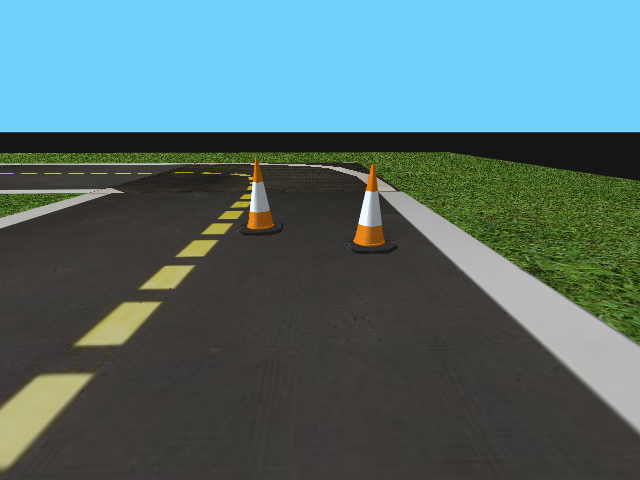

In [5]:
import random
from IPython.display import display

images_dir = repo_root / 'rag_database_lab' / 'example_images'
all_images = sorted([p for p in images_dir.glob('*.png')])
if not all_images:
    raise FileNotFoundError(f'No PNG images found in {images_dir}')

selected_image = random.choice(all_images)
print(f'Selected image: {selected_image.name}')

# Display the chosen image
try:
    from PIL import Image
    img = Image.open(selected_image)
    display(img)
except Exception as e:
    print('Could not open image with PIL:', e)

selected_image_path = str(selected_image)  # keep a str path for model calls

## 6. Iterative Rule Evaluation
We will ask Qwen about each rule separately to obtain an applicability score. Prompt schema aims for a JSON with fields: rule_id, score (0-100). Observe how VLM behaves with unclear rule database.

In [6]:
import time
from statistics import mean

# Ensure we have the runner instance; reuse existing if present
try:
    runner  # noqa: F821
except NameError:
    runner = None

if runner is None:
    # Fallback import if not already done
    from vlm_runners import VLMRunnerQwen25 # type: ignore
    runner = VLMRunnerQwen25(torch.device("cpu"))

iterative_results = []

# Load base_instruction from a .txt file if available
prompt_txt_path = repo_root / 'rag_database_lab' / 'base_instruction.txt'
if prompt_txt_path.exists():
    with open(prompt_txt_path, 'r', encoding='utf-8') as f:
        base_instruction = f.read().strip()

start_time = time.time()
image = Image.open(selected_image_path).convert('RGB')


for r in rules:  # iterate all loaded rules
    rule_id = r["id"]
    rule_text = r["text"]
    prompt = (
        f"{base_instruction}\nRule ID: {rule_id}, rule {rule_text}\n" 
        f"Analyze applicability. Return JSON only."
    )

    raw = runner.generate(image, prompt)
    iterative_results.append(raw)
    print(raw)    

```json
{"rule_id":"UNCONTROLLED_INTERSECTION","score":0}
```

Explanation: The image shows a road with two traffic cones placed in the center, suggesting a temporary or controlled area rather than an uncontrolled intersection. There is no clear indication of other vehicles or pedestrians, nor any signs of yielding to traffic from the right side. The presence of the cones implies that this might be a controlled area where caution is already being exercised, which contradicts the rule of approaching an uncontrolled intersection cautiously. Without clear evidence of an uncontrolled intersection, the rule cannot be applied definitively.
```json
{"rule_id":"OBSTACLE_AVOIDANCE","score":70}
```
Explanation: There are two traffic cones in the lane, which can be interpreted as obstacles that may require the vehicle to decelerate or change lanes to avoid them. The presence of these cones indicates a potential obstacle avoidance scenario. However, the image does not provide clear evidence of the

## 7. Batch Evaluation (All Rules at Once)
We provide all rules in a single prompt requesting a JSON array ranking applicability for the displayed image.

In [12]:
# Build batch prompt
rules_block_lines = [f"{r['id']}. {r['text']}" for r in rules]
rules_block = "\n".join(rules_block_lines)

# Load batch_instruction from a .txt file if available
batch_txt_path = repo_root / 'rag_database_lab' / 'batch_instruction.txt'
if batch_txt_path.exists():
    with open(batch_txt_path, 'r', encoding='utf-8') as f:
        batch_instruction = f.read().strip()
else:
    raise FileNotFoundError(f'Batch instruction file not found: {batch_txt_path}')

batch_prompt = (
    f"{batch_instruction}\nCandidate Rules:\n{rules_block}\n"
    f"Analyze the image and produce the output in the correct form."
)

batch_raw = runner.generate(image ,batch_prompt)
print(batch_raw)



[
"OBSTACLE_AVOIDANCE",
"LANE_KEEPING",
"SPEED_CONTROL",
"SAFE_SPEED",
"UNCONTROLLED_INTERSECTION"
]


## 8. Compare Iterative vs Batch Results
We align scores by rule_id, compute a simple correlation, and inspect agreement among top rules.

In [8]:
# Repair comparison logic for batch prompt that returns ONLY an ordered JSON array of rule_id strings.
# Batch output (batch_raw) contains strictly: ["RULE_ID_1", "RULE_ID_2", ..., "RULE_ID_N"]. No scores.
# Iterative results still include per-rule JSON objects with score + reason.

import re, json
from math import sqrt

# Helpers

def _extract_first_json_obj(text: str):
    m = re.search(r'\{[^{}]*\}', text, re.DOTALL)
    if not m:
        return None
    snippet = m.group(0)
    cleaned = snippet.replace("'", '"')
    cleaned = re.sub(r',\s*}', '}', cleaned)
    try:
        return json.loads(cleaned)
    except Exception:
        return None


def _norm_score(v):
    try:
        x = float(v)
    except Exception:
        return 0.0
    return max(0.0, min(1.0, x))

# Parse iterative (raw strings list aligned with rules order)
parsed_iter = []
for idx, raw in enumerate(iterative_results):
    rule_id = rules[idx]['id']
    rule_text = rules[idx]['text']
    obj = _extract_first_json_obj(raw) or {}
    score = _norm_score(obj.get('score', 0))
    reason = str(obj.get('reason', ''))[:300]
    parsed_iter.append({
        'rule_id': rule_id,
        'rule_text': rule_text,
        'score': score,
        'reason': reason,
        'raw': raw[:350]
    })

print(f"Parsed {len(parsed_iter)} iterative results with scores.")

# Parse batch: ordered array of rule_ids only
batch_order = []
batch_array_match = re.search(r'\[.*?\]', batch_raw, re.DOTALL)
if batch_array_match:
    snippet = batch_array_match.group(0)
    cleaned = snippet.replace("'", '"')
    # Remove trailing commas before closing bracket
    cleaned = re.sub(r',\s*]', ']', cleaned)
    try:
        data = json.loads(cleaned)
        if isinstance(data, list):
            batch_order = [str(x) for x in data]
    except Exception:
        batch_order = []

# Validate batch_order: ensure all rule_ids appear exactly once
expected_ids = [str(r['id']) for r in rules]
if set(batch_order) != set(expected_ids) or len(batch_order) != len(expected_ids):
    print("WARNING: Batch output missing or duplicating rule_ids. Attempting recovery.")
    # Fallback: if some IDs embedded individually, collect them preserving first occurrence order
    found_ids = []
    for rid in expected_ids:
        if rid in batch_raw and rid not in found_ids:
            found_ids.append(rid)
    if set(found_ids) == set(expected_ids):
        batch_order = found_ids

print(f"Parsed batch ordering of {len(batch_order)} rule_ids.")

# Build rank mapping (1-based). Earlier position => higher applicability.
batch_rank = {rid: i + 1 for i, rid in enumerate(batch_order)}
N = len(batch_order) if batch_order else 0

# Correlate iterative scores with batch ranking.
# Transform batch rank to a 'rank_score' where higher means more applicable: rank_score = N + 1 - rank
pairs = []
for entry in parsed_iter:
    rid = str(entry['rule_id'])
    if rid in batch_rank:
        iter_score = entry['score']
        rank_score = N + 1 - batch_rank[rid]
        pairs.append((iter_score, rank_score))

if pairs:
    xs = [p[0] for p in pairs]
    ys = [p[1] for p in pairs]
    mean_x = sum(xs)/len(xs)
    mean_y = sum(ys)/len(ys)
    num = sum((x-mean_x)*(y-mean_y) for x,y in pairs)
    den = (sum((x-mean_x)**2 for x in xs) * sum((y-mean_y)**2 for y in ys)) ** 0.5
    corr = num/den if den else 0.0
else:
    corr = 0.0

print(f"Correlation (iterative score vs batch rank position): {corr:.3f} over {len(pairs)} rules")

# Top-k iterative vs top-k batch (first k in ordering)
K = 5
iter_top_ids = [str(r['rule_id']) for r in sorted(parsed_iter, key=lambda x: x['score'], reverse=True)[:K]]
batch_top_ids = batch_order[:K]
overlap = sorted(set(iter_top_ids) & set(batch_top_ids))
print(f"Top-{K} overlap count: {len(overlap)} | IDs: {overlap}")

# Display alignment for overlapping rules
for rid in overlap:
    it_score = next(r['score'] for r in parsed_iter if str(r['rule_id']) == rid)
    brank = batch_rank.get(rid)
    text = next((r['text'] for r in rules if str(r['id']) == rid), '')
    print(f"Rule {rid}: iter_score={it_score:.2f} batch_rank={brank} | {text[:90]}")

# Build comparison summary structure
comparison_summary = {
    'correlation_iterative_score_vs_batch_rank': corr,
    'iter_top': iter_top_ids,
    'batch_top': batch_top_ids,
    'top_overlap': overlap,
    'iter_count': len(parsed_iter),
    'batch_count': N
}
comparison_summary

Parsed 6 iterative results with scores.
Parsed batch ordering of 4 rule_ids.
Correlation (iterative score vs batch rank position): 0.000 over 3 rules
Top-5 overlap count: 3 | IDs: ['LANE_KEEPING', 'OBSTACLE_AVOIDANCE', 'SAFE_SPEED']
Rule LANE_KEEPING: iter_score=1.00 batch_rank=2 | Keep centered within your lane; do not cross the lane midline. Reduce speed if lane confid
Rule OBSTACLE_AVOIDANCE: iter_score=1.00 batch_rank=1 | When an obstacle is in your lane, decelerate and bypass smoothly within your lane; stop if
Rule SAFE_SPEED: iter_score=1.00 batch_rank=4 | Adapt speed to curvature, visibility, and stopping distance. Slow before curves and inters


{'correlation_iterative_score_vs_batch_rank': 0.0,
 'iter_top': ['OBSTACLE_AVOIDANCE',
  'LANE_KEEPING',
  'SAFE_SPEED',
  'UNCONTROLLED_INTERSECTION',
  'PEDESTRIAN_AWARENESS'],
 'batch_top': ['OBSTACLE_AVOIDANCE',
  'LANE_KEEPING',
  'SPEED_ADJUSTMENT',
  'SAFE_SPEED'],
 'top_overlap': ['LANE_KEEPING', 'OBSTACLE_AVOIDANCE', 'SAFE_SPEED'],
 'iter_count': 6,
 'batch_count': 4}

## 9. CLIP Embedding-Based Rule Retrieval
Use a dual-encoder (CLIP) to embed the selected image and all rule texts, rank rules by cosine similarity, and compare with Qwen batch ordering & iterative scores.

In [9]:
# Initialize CLIP retriever and compute rule/image embeddings
from clip_rule_retrieval import CLIPRuleImageRetriever, compute_metrics
from PIL import Image
import torch

clip_device = 'cuda' if torch.cuda.is_available() else 'cpu'
retriever = CLIPRuleImageRetriever(device=clip_device)
print(f'Loaded CLIP model on {clip_device}')

# Ensure image object exists
if 'image' not in globals():
    image = Image.open(selected_image_path).convert('RGB')

# Embed rules (list of dicts with id, text)
rule_embs, rule_ids, rule_texts = retriever.embed_rules(rules)
print(f'Embedded {len(rule_ids)} rules -> tensor shape {tuple(rule_embs.shape)}')

# Embed image
img_emb = retriever.embed_image(image)
print('Image embedding shape:', tuple(img_emb.shape))

# Rank rules by similarity
top_k = min(10, len(rule_ids))
ranking = retriever.rank_rules(img_emb, rule_embs, rule_ids, rule_texts, top_k=top_k)

print('\nTop CLIP rule ranking:')
for r in ranking:
    print(f"rule_id={r['rule_id']} sim={r['similarity']:.4f} | {r['rule_text'][:90]}")

# Prepare metrics inputs
clip_rank_ids = [str(r['rule_id']) for r in ranking]  # truncated list
full_clip_rank_ids = [str(r['rule_id']) for r in retriever.rank_rules(img_emb, rule_embs, rule_ids, rule_texts, top_k=None)]
iter_scores_map = {str(e['rule_id']): e['score'] for e in parsed_iter}

# Compute metrics using full ordering vs batch_order (if available)
metrics = compute_metrics(full_clip_rank_ids, batch_order, iter_scores_map, k=5)
print('\nExample metrics summary:')
for k,v in metrics.items():
    if isinstance(v, float):
        print(f'{k}: {v:.4f}')
    else:
        print(f'{k}: {v}')

clip_metrics = metrics  # expose for later cells

Loaded CLIP model on cuda
Embedded 6 rules -> tensor shape (6, 512)
Image embedding shape: (1, 512)

Top CLIP rule ranking:
rule_id=SAFE_SPEED sim=0.2886 | Adapt speed to curvature, visibility, and stopping distance. Slow before curves and inters
rule_id=OBSTACLE_AVOIDANCE sim=0.2842 | When an obstacle is in your lane, decelerate and bypass smoothly within your lane; stop if
rule_id=LANE_KEEPING sim=0.2834 | Keep centered within your lane; do not cross the lane midline. Reduce speed if lane confid
rule_id=PASSING_OVERTAKING sim=0.2822 | Pass only when permitted by the lane layout and safe within your lane; ensure visibility a
rule_id=UNCONTROLLED_INTERSECTION sim=0.2587 | Approach an uncontrolled intersection cautiously, be ready to stop, yield to vehicles in t
rule_id=PEDESTRIAN_AWARENESS sim=0.2313 | Yield to pedestrians or ducks entering or occupying your path; slow to a crawl and stop if

Example metrics summary:
spearman_clip_vs_batch: -1.7500
topk_overlap_count: 3
topk_overlap_id

## 10. Own code 
Under this section develop your own code for the laboratory. If you'll face any problems, use examples above.

In [ ]:
#code